# XAI Predictive Maintenance - Vollständige Analyse

Dieses Notebook führt eine vollständige Analyse für Predictive Maintenance durch:
1. Datenvorbereitung
2. Modelltraining (Random Forest & Decision Tree)
3. Evaluation & Vergleich
4. SHAP Explainability Analyse
5. Visualisierung mit Graphviz

---
## 1. Importieren der benötigten Programmbibliotheken

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Graphviz for tree visualization
import graphviz
from IPython.display import Image, display

# SHAP for Explainability
import shap

# Settings
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
np.random.seed(42)

print("✓ Alle Bibliotheken erfolgreich importiert!")

✓ Alle Bibliotheken erfolgreich importiert!


---
## 2. Datenvorbereitung: Daten einlesen

In [2]:
# Daten laden
data_path = '../data/raw/automotive_data_train_140.csv'
df = pd.read_csv(data_path, sep=';', encoding='utf-8')

print(f"Datensatz geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten")
print(f"\nErste 5 Zeilen:")
df.head()

Datensatz geladen: 140 Zeilen, 24 Spalten

Erste 5 Zeilen:


,Messungsnr,Ausfall,Kuehlmitteltemp,EinspritzmKurz,EinspritzmLang,Kraftstoffdruck,Ansaugkrdruck,Drosselklstellung,Einlasslufttemp,LS11,...,LS22.1,LS32,LS42,Kraftstoffleitdruck,Abgasrueckf,Kraftstoffdampfsaeub.,Kraftstoffeinsatz,EVAPDruck,Luftdruck,KatTemp
0,M_001,nein,2.8,0.9,3.8,15.0,23.4,14.8,1.6,1.5,...,0.1,0.5,2.5,2.0,1.8,3.3,1.1,1.9,2.5,NaN
1,M_002,ja,9.9,24.6,15.0,8.6,5.7,3.0,1.2,0.8,...,3.0,0.4,0.2,0.7,0.8,1.2,0.7,2.8,2.8,NaN
2,M_003,nein,3.4,28.5,8.7,4.7,3.7,3.0,1.8,1.5,...,0.8,1.3,1.3,1.3,1.2,1.0,0.9,0.1,0.1,NaN
3,M_004,ja,2.8,2.8,6.3,7.4,23.8,17.1,2.4,2.2,...,0.3,0.8,0.6,1.1,1.4,1.1,0.7,0.4,0.1,NaN
4,M_005,nein,4.9,15.4,25.9,13.0,5.5,4.1,1.5,1.1,...,1.6,0.3,0.1,1.1,0.8,1.8,2.2,3.0,3.0,NaN


In [3]:
# Datensatz-Informationen
print("Datensatz-Info:")
print(df.info())

print("\nStatistische Zusammenfassung:")
df.describe()

Datensatz-Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Messungsnr             140 non-null    object 
 1   Ausfall                140 non-null    object 
 2   Kuehlmitteltemp        140 non-null    float64
 3   EinspritzmKurz         140 non-null    float64
 4   EinspritzmLang         140 non-null    float64
 5   Kraftstoffdruck        140 non-null    float64
 6   Ansaugkrdruck          140 non-null    float64
 7   Drosselklstellung      140 non-null    float64
 8   Einlasslufttemp        140 non-null    float64
 9   LS11                   140 non-null    float64
 10  LS21                   140 non-null    float64
 11  LS22                   140 non-null    float64
 12  LS41                   140 non-null    float64
 13  LS12                   140 non-null    float64
 14  LS22.1                 140 non-null    flo

,Kuehlmitteltemp,EinspritzmKurz,EinspritzmLang,Kraftstoffdruck,Ansaugkrdruck,Drosselklstellung,Einlasslufttemp,LS11,LS21,LS22,...,LS22.1,LS32,LS42,Kraftstoffleitdruck,Abgasrueckf,Kraftstoffdampfsaeub.,Kraftstoffeinsatz,EVAPDruck,Luftdruck,KatTemp
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,0.0
mean,3.055000,7.317857,13.070714,13.584286,12.051429,6.744286,2.877857,1.655714,1.375714,1.110714,...,1.493571,1.569286,1.550000,1.562857,1.602143,1.630000,1.587143,1.628571,1.677143,NaN
std,2.042721,7.323003,9.990107,8.772966,9.105753,5.676599,2.658205,1.233074,0.857541,0.633785,...,1.120522,0.894741,0.830229,0.807104,0.774640,0.811225,0.813010,1.195994,1.230625,NaN
min,0.200000,0.500000,0.400000,0.600000,0.500000,0.500000,0.100000,0.100000,0.200000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,NaN
25%,1.700000,2.400000,3.800000,6.775000,4.875000,2.900000,1.300000,0.900000,0.800000,0.600000,...,0.400000,0.875000,0.900000,0.875000,1.000000,1.000000,0.800000,0.375000,0.300000,NaN
50%,2.700000,4.400000,10.750000,10.700000,8.900000,4.900000,2.100000,1.500000,1.300000,1.000000,...,1.450000,1.600000,1.600000,1.500000,1.550000,1.700000,1.700000,1.800000,2.150000,NaN
75%,4.050000,10.025000,22.000000,20.600000,18.400000,9.200000,3.400000,2.000000,1.725000,1.500000,...,2.600000,2.300000,2.300000,2.300000,2.225000,2.300000,2.300000,2.800000,2.825000,NaN
max,11.200000,32.500000,32.100000,34.000000,32.600000,28.200000,15.300000,9.700000,5.700000,3.300000,...,3.100000,3.200000,3.300000,3.100000,3.200000,3.300000,3.100000,3.300000,3.300000,NaN


Verteilung der Zielvariable 'Ausfall':
Ausfall
ja      81
nein    59
Name: count, dtype: int64


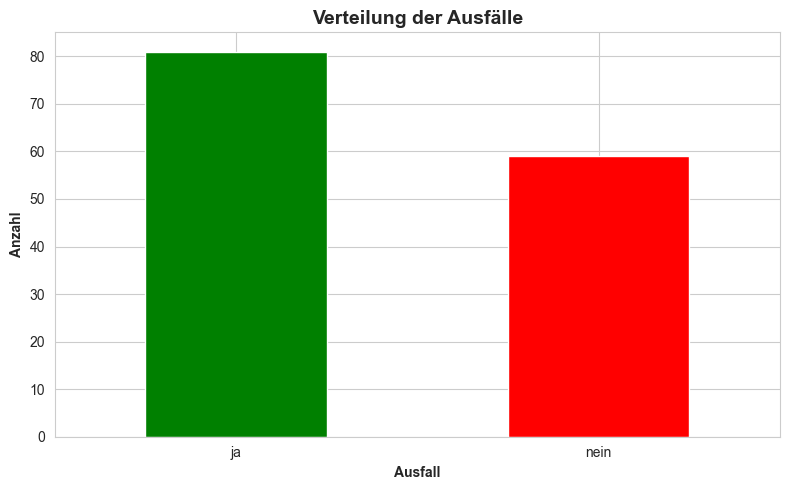


Prozentuale Verteilung:
Ausfall
ja      57.857143
nein    42.142857
Name: proportion, dtype: float64


In [4]:
# Zielvariable analysieren
print("Verteilung der Zielvariable 'Ausfall':")
print(df['Ausfall'].value_counts())

# Visualisierung
plt.figure(figsize=(8, 5))
df['Ausfall'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Verteilung der Ausfälle', fontsize=14, fontweight='bold')
plt.xlabel('Ausfall', fontweight='bold')
plt.ylabel('Anzahl', fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Prozentuale Verteilung
print(f"\nProzentuale Verteilung:")
print(df['Ausfall'].value_counts(normalize=True) * 100)

---
## 3. Datenvorbereitung: Merkmale und Zielvariable extrahieren

In [5]:
# Zielvariable kodieren: 'ja' -> 1, 'nein' -> 0
df['Ausfall'] = df['Ausfall'].map({'ja': 1, 'nein': 0})

print("✓ Zielvariable kodiert")
print(f"  - 'ja' (Ausfall) = 1")
print(f"  - 'nein' (Kein Ausfall) = 0")

✓ Zielvariable kodiert
  - 'ja' (Ausfall) = 1
  - 'nein' (Kein Ausfall) = 0


In [6]:
# Unnötige Spalten entfernen
columns_to_drop = ['Messungsnr', 'KatTemp']
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

print(f"✓ Spalten entfernt: {columns_to_drop}")
print(f"✓ Bereinigte Daten: {df_clean.shape}")

✓ Spalten entfernt: ['Messungsnr', 'KatTemp']
✓ Bereinigte Daten: (140, 22)


In [7]:
# Features (X) und Zielvariable (y) trennen
X = df_clean.drop('Ausfall', axis=1)
y = df_clean['Ausfall']

feature_names = list(X.columns)

print(f"✓ Features (X): {X.shape}")
print(f"✓ Zielvariable (y): {y.shape}")
print(f"\nAnzahl Features: {len(feature_names)}")
print(f"\nFeature-Namen:")
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")

✓ Features (X): (140, 21)
✓ Zielvariable (y): (140,)

Anzahl Features: 21

Feature-Namen:
   1. Kuehlmitteltemp
   2. EinspritzmKurz
   3. EinspritzmLang
   4. Kraftstoffdruck
   5. Ansaugkrdruck
   6. Drosselklstellung
   7. Einlasslufttemp
   8. LS11
   9. LS21
  10. LS22
  11. LS41
  12. LS12
  13. LS22.1
  14. LS32
  15. LS42
  16. Kraftstoffleitdruck
  17. Abgasrueckf
  18. Kraftstoffdampfsaeub.
  19. Kraftstoffeinsatz
  20. EVAPDruck
  21. Luftdruck


---
## 4. Datenvorbereitung: Aufteilen in Trainings- und Testdaten

In [8]:
# Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Gleiche Verteilung in Train und Test
)

print("✓ Daten aufgeteilt:")
print(f"  - Training Set: {len(X_train)} Samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test Set:     {len(X_test)} Samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n✓ Verteilung der Ausfälle:")
print(f"  - Training: {y_train.value_counts().to_dict()}")
print(f"  - Test:     {y_test.value_counts().to_dict()}")

✓ Daten aufgeteilt:
  - Training Set: 112 Samples (80.0%)
  - Test Set:     28 Samples (20.0%)

✓ Verteilung der Ausfälle:
  - Training: {1: 65, 0: 47}
  - Test:     {1: 16, 0: 12}


In [9]:
# Feature Skalierung (Standardisierung)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features standardisiert (Mittelwert=0, Standardabweichung=1)")
print(f"\nBeispiel - Mittelwerte nach Skalierung (sollten ~0 sein):")
print(X_train_scaled.mean(axis=0)[:5])

✓ Features standardisiert (Mittelwert=0, Standardabweichung=1)

Beispiel - Mittelwerte nach Skalierung (sollten ~0 sein):
[-4.55984457e-17  1.82393783e-16 -6.34413157e-17 -3.37031990e-17
 -7.93016446e-18]


---
## 5. Vorhersagemodell erstellen: Random Forest

In [10]:
# Random Forest Modell erstellen
rf_model = RandomForestClassifier(
    n_estimators=100,        # 100 Entscheidungsbäume
    max_depth=10,            # Maximale Tiefe der Bäume
    min_samples_split=5,     # Minimale Samples für Split
    min_samples_leaf=2,      # Minimale Samples in Blatt
    class_weight='balanced', # Ausgleich unbalancierter Klassen
    random_state=42,
    n_jobs=-1                # Alle CPU-Kerne nutzen
)

print("✓ Random Forest Modell erstellt")
print(f"\nParameter:")
print(f"  - Anzahl Bäume: {rf_model.n_estimators}")
print(f"  - Maximale Tiefe: {rf_model.max_depth}")
print(f"  - Min. Samples Split: {rf_model.min_samples_split}")
print(f"  - Min. Samples Leaf: {rf_model.min_samples_leaf}")

✓ Random Forest Modell erstellt

Parameter:
  - Anzahl Bäume: 100
  - Maximale Tiefe: 10
  - Min. Samples Split: 5
  - Min. Samples Leaf: 2


In [11]:
# Cross-Validation (5-Fold)
print("Kreuzvalidierung (5-Fold) läuft...")

cv_scores = cross_val_score(
    rf_model, X_train_scaled, y_train,
    cv=5,
    scoring='f1'
)

print(f"\n✓ Kreuzvalidierung abgeschlossen")
print(f"\nF1-Scores pro Fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nDurchschnitt: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

Kreuzvalidierung (5-Fold) läuft...

✓ Kreuzvalidierung abgeschlossen

F1-Scores pro Fold:
  Fold 1: 0.8148
  Fold 2: 0.7407
  Fold 3: 0.7200
  Fold 4: 0.7826
  Fold 5: 0.6957

Durchschnitt: 0.7508 (± 0.0429)


In [12]:
# Modell trainieren
print("Training des Random Forest Modells...")

rf_model.fit(X_train_scaled, y_train)

print("✓ Training abgeschlossen!")
print(f"\nModell-Details:")
print(f"  - Trainierte Bäume: {len(rf_model.estimators_)}")
print(f"  - Anzahl Features: {rf_model.n_features_in_}")
print(f"  - Klassen: {rf_model.classes_}")

Training des Random Forest Modells...
✓ Training abgeschlossen!

Modell-Details:
  - Trainierte Bäume: 100
  - Anzahl Features: 21
  - Klassen: [0 1]


---
## 6. Vorhersagemodell erstellen: Decision Tree (Vergleich)

In [13]:
# Decision Tree Modell erstellen
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=0.1,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)

# Cross-Validation
dt_cv_scores = cross_val_score(
    dt_model, X_train_scaled, y_train,
    cv=5,
    scoring='f1'
)

# Training
dt_model.fit(X_train_scaled, y_train)

print("✓ Decision Tree trainiert")
print(f"  - CV F1-Score: {dt_cv_scores.mean():.4f} (± {dt_cv_scores.std():.4f})")
print(f"  - Baum-Tiefe: {dt_model.get_depth()}")
print(f"  - Anzahl Blätter: {dt_model.get_n_leaves()}")

✓ Decision Tree trainiert
  - CV F1-Score: 0.8123 (± 0.0201)
  - Baum-Tiefe: 5
  - Anzahl Blätter: 11


---
## 7. Vorhersagemodell visualisieren (mit Graphviz)

In [14]:
# Helper function for Graphviz visualization (CORRECTED)
def visualize_tree_graphviz(model, feature_names, class_names, title, max_depth=4):
    """
    Visualize decision tree using Graphviz
    
    Args:
        model: Trained tree model
        feature_names: List of feature names
        class_names: List of class names
        title: Title for the tree
        max_depth: Maximum depth to display
    """
    # Export tree to DOT format
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True,
        max_depth=max_depth,
        proportion=True,
        precision=2
    )
    
    # Add title to the DOT data
    # Insert label after "digraph Tree {"
    dot_data = dot_data.replace(
        'digraph Tree {',
        f'digraph Tree {{\n    label="{title}";\n    labelloc="t";\n    fontsize=20;\n    fontname="Arial Bold";'
    )
    
    # Create graph
    graph = graphviz.Source(dot_data)
    
    return graph

print("✓ Graphviz Visualisierungs-Funktion definiert (korrigiert)")

✓ Graphviz Visualisierungs-Funktion definiert (korrigiert)


Visualisierung: Random Forest - Baum #0 (mit Graphviz)
Tiefe begrenzt auf 4 Ebenen für bessere Lesbarkeit


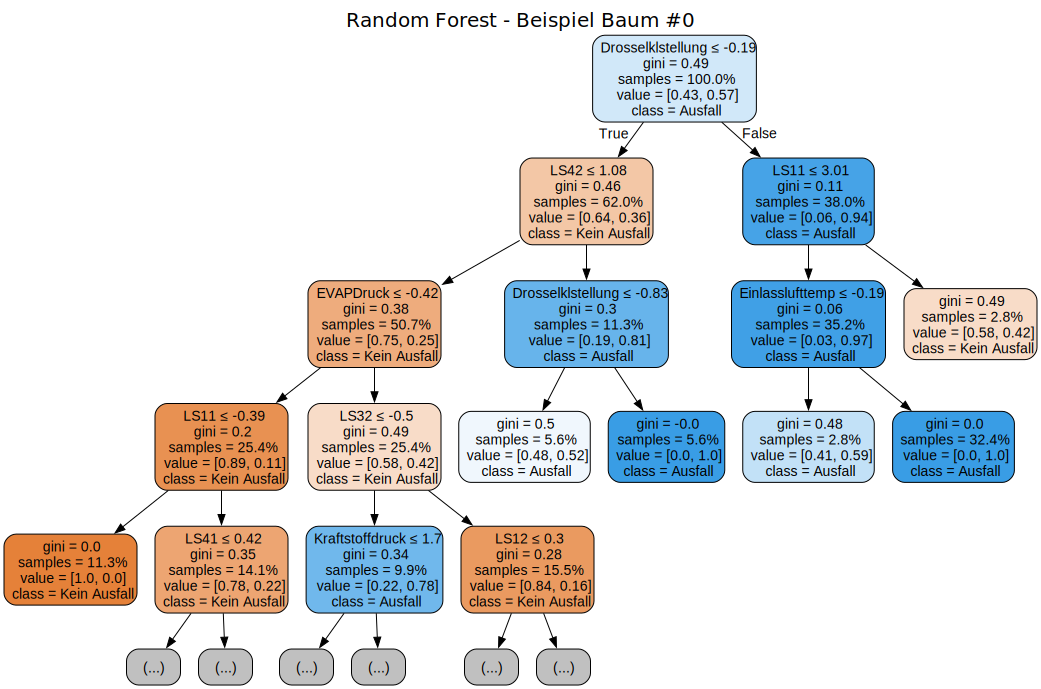

In [15]:
# Random Forest - Einzelner Baum mit Graphviz
print("Visualisierung: Random Forest - Baum #0 (mit Graphviz)")
print("Tiefe begrenzt auf 4 Ebenen für bessere Lesbarkeit")

rf_tree_graph = visualize_tree_graphviz(
    rf_model.estimators_[0],
    feature_names=feature_names,
    class_names=['Kein Ausfall', 'Ausfall'],
    title='Random Forest - Beispiel Baum #0',
    max_depth=4
)

display(rf_tree_graph)

Visualisierung: Decision Tree (mit Graphviz)
Tiefe begrenzt auf 4 Ebenen für bessere Lesbarkeit


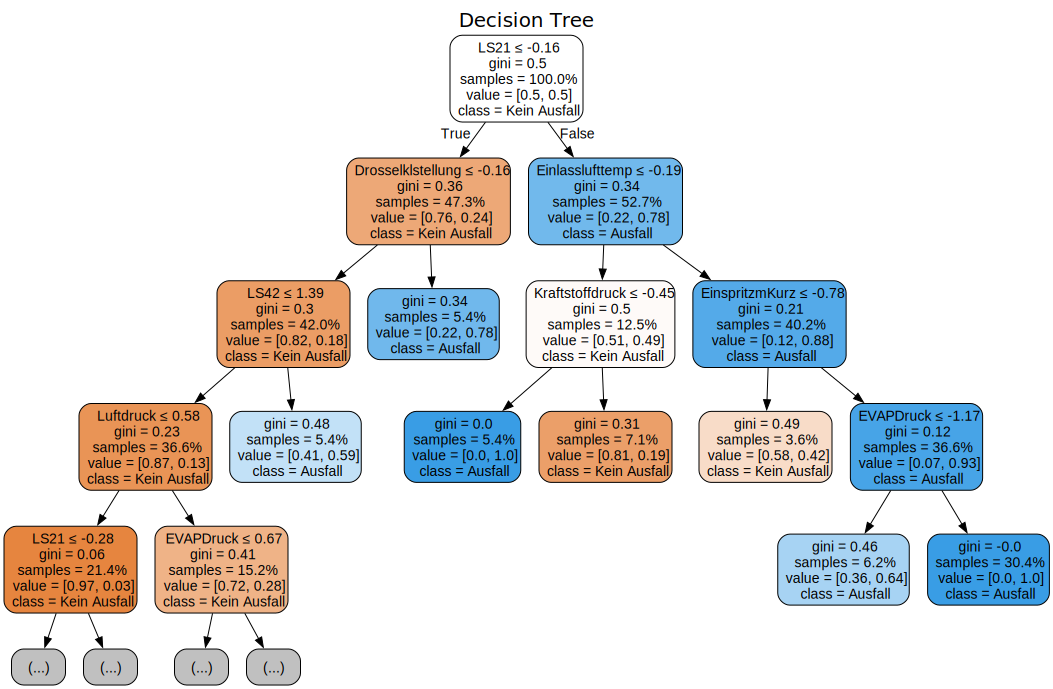

In [16]:
# Decision Tree mit Graphviz
print("Visualisierung: Decision Tree (mit Graphviz)")
print("Tiefe begrenzt auf 4 Ebenen für bessere Lesbarkeit")

dt_tree_graph = visualize_tree_graphviz(
    dt_model,
    feature_names=feature_names,
    class_names=['Kein Ausfall', 'Ausfall'],
    title='Decision Tree',
    max_depth=4
)

display(dt_tree_graph)

In [17]:
# Optional: Save trees as PDF
output_dir = Path('../results/tree_visualizations')
output_dir.mkdir(parents=True, exist_ok=True)

# Save Random Forest tree
rf_tree_graph.render(output_dir / 'random_forest_tree_0', format='pdf', cleanup=True)
print(f"✓ Random Forest Baum gespeichert: {output_dir / 'random_forest_tree_0.pdf'}")

# Save Decision Tree
dt_tree_graph.render(output_dir / 'decision_tree', format='pdf', cleanup=True)
print(f"✓ Decision Tree gespeichert: {output_dir / 'decision_tree.pdf'}")

✓ Random Forest Baum gespeichert: ..\results\tree_visualizations\random_forest_tree_0.pdf
✓ Decision Tree gespeichert: ..\results\tree_visualizations\decision_tree.pdf


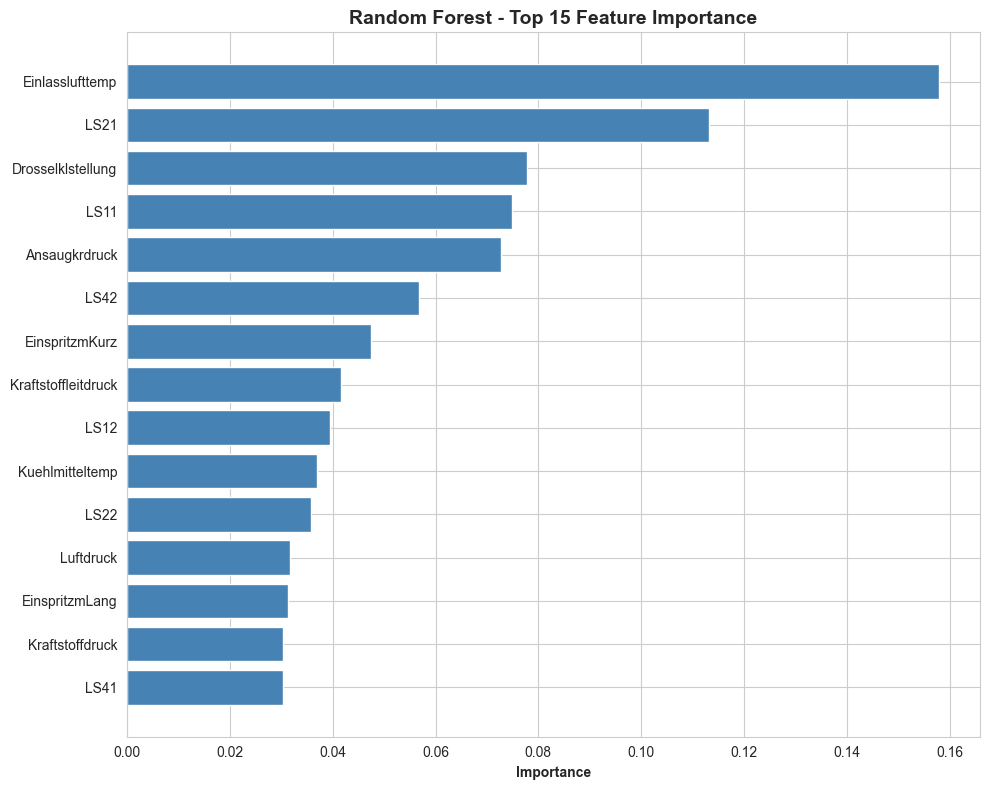


Top 10 wichtigste Features:
            Feature  Importance
    Einlasslufttemp    0.158016
               LS21    0.113178
  Drosselklstellung    0.077749
               LS11    0.074837
      Ansaugkrdruck    0.072719
               LS42    0.056878
     EinspritzmKurz    0.047465
Kraftstoffleitdruck    0.041632
               LS12    0.039457
    Kuehlmitteltemp    0.036919


In [18]:
# Feature Importance (Random Forest)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance['Importance'][:15], color='steelblue')
plt.yticks(range(15), feature_importance['Feature'][:15])
plt.xlabel('Importance', fontweight='bold')
plt.title('Random Forest - Top 15 Feature Importance', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 wichtigste Features:")
print(feature_importance.head(10).to_string(index=False))

---
## 8. Performance-Kennzahlen: Evaluation

In [19]:
# Vorhersagen auf Trainings- und Testdaten
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

dt_train_pred = dt_model.predict(X_train_scaled)
dt_test_pred = dt_model.predict(X_test_scaled)

In [20]:
# Random Forest Performance
print("="*70)
print("RANDOM FOREST - PERFORMANCE")
print("="*70)

print("\nTraining Set:")
print(f"  Accuracy:  {accuracy_score(y_train, rf_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train, rf_train_pred):.4f}")
print(f"  Recall:    {recall_score(y_train, rf_train_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_train, rf_train_pred):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, rf_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, rf_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, rf_test_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, rf_test_pred):.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, rf_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, rf_test_pred, target_names=['Kein Ausfall', 'Ausfall']))

RANDOM FOREST - PERFORMANCE

Training Set:
  Accuracy:  0.9821
  Precision: 0.9846
  Recall:    0.9846
  F1-Score:  0.9846

Test Set:
  Accuracy:  0.7857
  Precision: 0.7500
  Recall:    0.9375
  F1-Score:  0.8333

Confusion Matrix (Test):
[[ 7  5]
 [ 1 15]]

Classification Report (Test):
              precision    recall  f1-score   support

Kein Ausfall       0.88      0.58      0.70        12
     Ausfall       0.75      0.94      0.83        16

    accuracy                           0.79        28
   macro avg       0.81      0.76      0.77        28
weighted avg       0.80      0.79      0.78        28



In [21]:
# Decision Tree Performance
print("="*70)
print("DECISION TREE - PERFORMANCE")
print("="*70)

print("\nTraining Set:")
print(f"  Accuracy:  {accuracy_score(y_train, dt_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train, dt_train_pred):.4f}")
print(f"  Recall:    {recall_score(y_train, dt_train_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_train, dt_train_pred):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, dt_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, dt_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, dt_test_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, dt_test_pred):.4f}")

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, dt_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, dt_test_pred, target_names=['Kein Ausfall', 'Ausfall']))

DECISION TREE - PERFORMANCE

Training Set:
  Accuracy:  0.8929
  Precision: 0.9206
  Recall:    0.8923
  F1-Score:  0.9062

Test Set:
  Accuracy:  0.7143
  Precision: 0.7000
  Recall:    0.8750
  F1-Score:  0.7778

Confusion Matrix (Test):
[[ 6  6]
 [ 2 14]]

Classification Report (Test):
              precision    recall  f1-score   support

Kein Ausfall       0.75      0.50      0.60        12
     Ausfall       0.70      0.88      0.78        16

    accuracy                           0.71        28
   macro avg       0.72      0.69      0.69        28
weighted avg       0.72      0.71      0.70        28




MODELL-VERGLEICH (Test Set)
   Metric  Random Forest  Decision Tree  Differenz (RF - DT)
 Accuracy       0.785714       0.714286             0.071429
Precision       0.750000       0.700000             0.050000
   Recall       0.937500       0.875000             0.062500
 F1-Score       0.833333       0.777778             0.055556


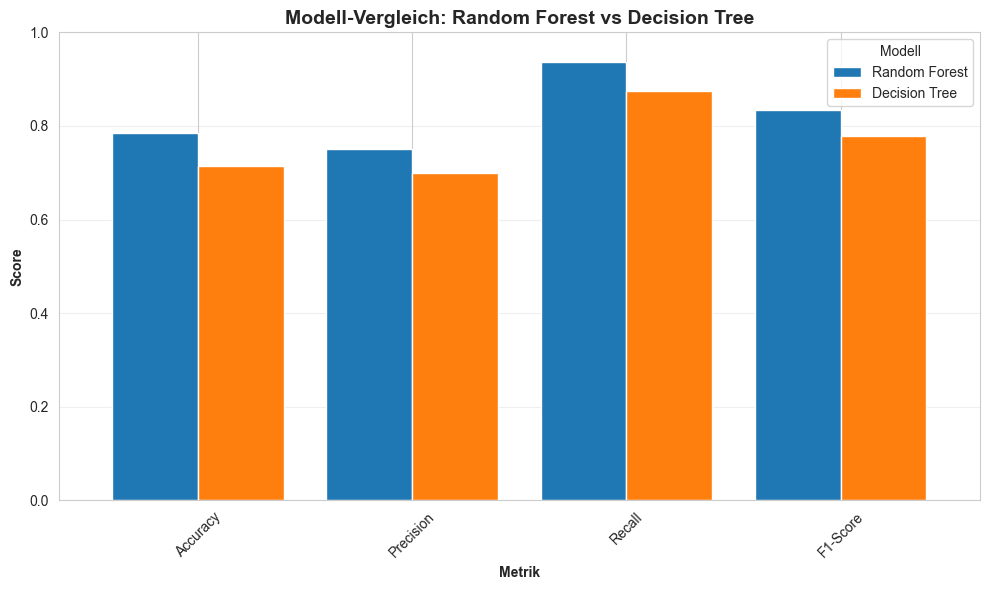

In [22]:
# Modell-Vergleich Tabelle
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [
        accuracy_score(y_test, rf_test_pred),
        precision_score(y_test, rf_test_pred),
        recall_score(y_test, rf_test_pred),
        f1_score(y_test, rf_test_pred)
    ],
    'Decision Tree': [
        accuracy_score(y_test, dt_test_pred),
        precision_score(y_test, dt_test_pred),
        recall_score(y_test, dt_test_pred),
        f1_score(y_test, dt_test_pred)
    ]
})

comparison['Differenz (RF - DT)'] = comparison['Random Forest'] - comparison['Decision Tree']

print("\n" + "="*70)
print("MODELL-VERGLEICH (Test Set)")
print("="*70)
print(comparison.to_string(index=False))

# Visualisierung
comparison_plot = comparison[['Metric', 'Random Forest', 'Decision Tree']].set_index('Metric')

ax = comparison_plot.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Modell-Vergleich: Random Forest vs Decision Tree', fontweight='bold', fontsize=14)
plt.ylabel('Score', fontweight='bold')
plt.xlabel('Metrik', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Modell')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 9. SHAP Explainability Analyse

In [23]:
# SHAP Explainer erstellen
print("SHAP TreeExplainer wird erstellt...")

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Für binäre Klassifikation: positive Klasse (Ausfall = 1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]
elif len(shap_values.shape) == 3:
    shap_values = shap_values[:, :, 1]

print(f"✓ SHAP Werte berechnet: {shap_values.shape}")
print(f"  - {shap_values.shape[0]} Test-Samples")
print(f"  - {shap_values.shape[1]} Features")

SHAP TreeExplainer wird erstellt...
✓ SHAP Werte berechnet: (28, 21)
  - 28 Test-Samples
  - 21 Features


C:\Users\dargu\AppData\Local\Temp\ipykernel_29904\1144177060.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)


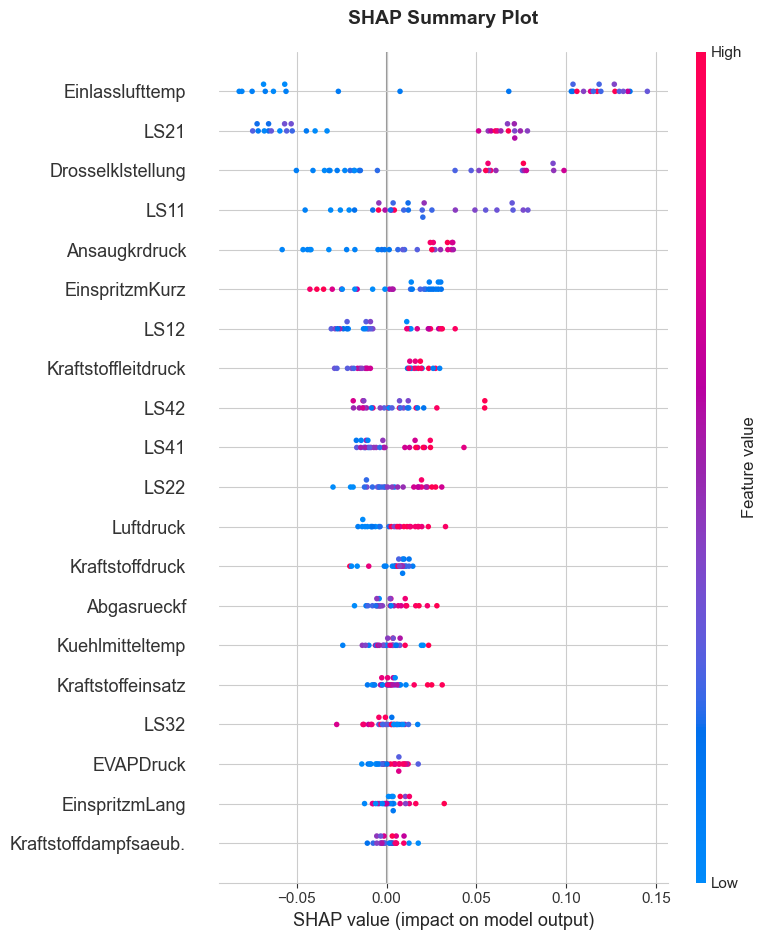

In [24]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

C:\Users\dargu\AppData\Local\Temp\ipykernel_29904\1708923029.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type='bar', show=False)


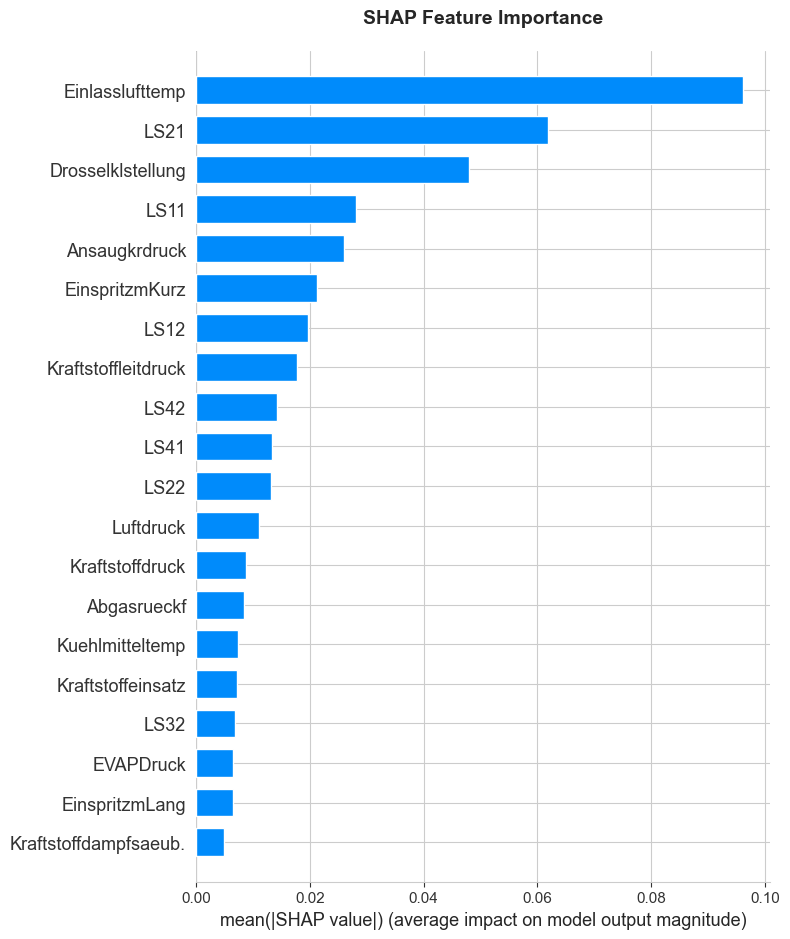

In [25]:
# SHAP Feature Importance (Bar Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Feature Importance', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

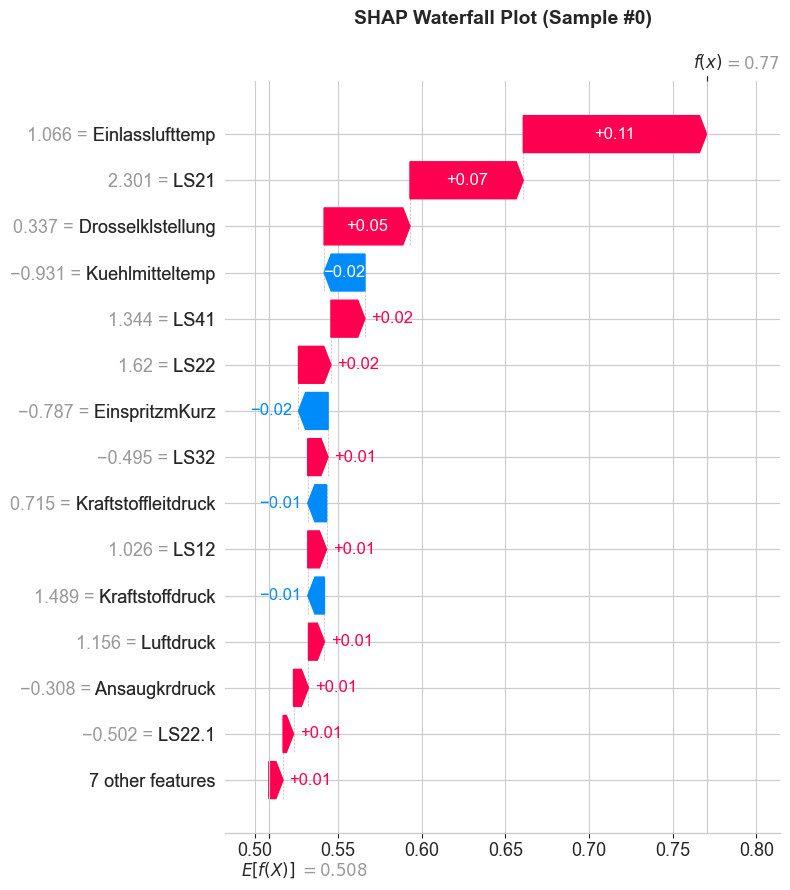

In [26]:
# SHAP Waterfall Plot
sample_idx = 0

# 1D SHAP Vector
shap_vec = shap_values[sample_idx]

# Base Value for positive class (Ausfall = 1)
base_val = explainer.expected_value[1] if hasattr(explainer.expected_value, "__len__") else explainer.expected_value

# Feature values
sample_data = X_test_scaled[sample_idx]

# Build explanation object
expl = shap.Explanation(
    values=shap_vec,
    base_values=base_val,
    data=sample_data,
    feature_names=feature_names
)

plt.figure(figsize=(10, 8))
shap.plots.waterfall(expl, max_display=15, show=False)
plt.title(f"SHAP Waterfall Plot (Sample #{sample_idx})",
          fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [27]:
# Top 10 Features nach SHAP
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP Importance', ascending=False)

print("\nTop 10 Features nach SHAP Importance:")
print("="*60)
for i, (idx, row) in enumerate(shap_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:30s} : {row['SHAP Importance']:.4f}")


Top 10 Features nach SHAP Importance:
 1. Einlasslufttemp                : 0.0961
 2. LS21                           : 0.0618
 3. Drosselklstellung              : 0.0481
 4. LS11                           : 0.0282
 5. Ansaugkrdruck                  : 0.0261
 6. EinspritzmKurz                 : 0.0212
 7. LS12                           : 0.0196
 8. Kraftstoffleitdruck            : 0.0177
 9. LS42                           : 0.0143
10. LS41                           : 0.0134


---
## 10. Zusammenfassung & Fazit

In [28]:
print("="*70)
print("ZUSAMMENFASSUNG")
print("="*70)

print("\n1. DATENSATZ:")
print(f"   - Gesamt: {len(df)} Samples")
print(f"   - Training: {len(X_train)} Samples")
print(f"   - Test: {len(X_test)} Samples")
print(f"   - Features: {len(feature_names)}")

print("\n2. MODELLE:")
print(f"   - Random Forest: {rf_model.n_estimators} Bäume")
print(f"   - Decision Tree: 1 Baum")

print("\n3. PERFORMANCE (Test Set):")
print(f"   Random Forest:")
print(f"     - Accuracy:  {accuracy_score(y_test, rf_test_pred):.1%}")
print(f"     - F1-Score:  {f1_score(y_test, rf_test_pred):.1%}")
print(f"   Decision Tree:")
print(f"     - Accuracy:  {accuracy_score(y_test, dt_test_pred):.1%}")
print(f"     - F1-Score:  {f1_score(y_test, dt_test_pred):.1%}")

print("\n4. WICHTIGSTE FEATURES (SHAP):")
for i, (idx, row) in enumerate(shap_importance.head(3).iterrows(), 1):
    print(f"   {i}. {row['Feature']}")

print("\n5. VISUALISIERUNG:")
print(f"   ✓ Graphviz Baumvisualisierungen erstellt")
print(f"   ✓ PDFs gespeichert in: {output_dir}")

print("\n6. FAZIT:")
winner = 'Random Forest' if f1_score(y_test, rf_test_pred) > f1_score(y_test, dt_test_pred) else 'Decision Tree'
print(f"   ✓ {winner} zeigt die beste Performance")
print(f"   ✓ SHAP ermöglicht Interpretierbarkeit des Modells")
print(f"   ✓ Graphviz bietet hochqualitative Baumvisualisierungen")
print(f"   ✓ Vorhersage von Ausfällen mit {accuracy_score(y_test, rf_test_pred):.1%} Genauigkeit möglich")

print("\n" + "="*70)

ZUSAMMENFASSUNG

1. DATENSATZ:
   - Gesamt: 140 Samples
   - Training: 112 Samples
   - Test: 28 Samples
   - Features: 21

2. MODELLE:
   - Random Forest: 100 Bäume
   - Decision Tree: 1 Baum

3. PERFORMANCE (Test Set):
   Random Forest:
     - Accuracy:  78.6%
     - F1-Score:  83.3%
   Decision Tree:
     - Accuracy:  71.4%
     - F1-Score:  77.8%

4. WICHTIGSTE FEATURES (SHAP):
   1. Einlasslufttemp
   2. LS21
   3. Drosselklstellung

5. VISUALISIERUNG:
   ✓ Graphviz Baumvisualisierungen erstellt
   ✓ PDFs gespeichert in: ..\results\tree_visualizations

6. FAZIT:
   ✓ Random Forest zeigt die beste Performance
   ✓ SHAP ermöglicht Interpretierbarkeit des Modells
   ✓ Graphviz bietet hochqualitative Baumvisualisierungen
   ✓ Vorhersage von Ausfällen mit 78.6% Genauigkeit möglich



---
## Notebook Ende